# This approach is not as good as the approach in the "random-forest" notebook

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import math
import jellyfish
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

from matchers import metrics, utils, dataset
from matchers.models.randomforest import get_editops, get_features_targets

In [3]:
np.set_printoptions(suppress=True)
tqdm.pandas()

### Load and process data

In [4]:
# Only need to run this once
# It we split the data into train/test and will persist the data on disk
# dataset.load_split_init(test_size=0.1)

In [5]:
train, test = dataset.load_process_from_disk()

input_names_train, weighted_relevant_names_train, all_candidates_train = train
input_names_test, weighted_relevant_names_test, all_candidates_test = test

all_candidates = np.concatenate((all_candidates_train, all_candidates_test))

### Model

In [6]:
# compute transitions and editops
train_editops_counts = []
editop_counts = defaultdict(int)

for tree_name, record_names in zip(input_names_train, weighted_relevant_names_train):
    for weighted_record_name in record_names:
        # weighted_record_name = (name, weight, co-occurrence count)
        editops = get_editops(weighted_record_name[0], tree_name)
        train_editops_counts.append((editops, weighted_record_name[2]))
        for editop in editops:
            editop_counts[editop] += weighted_record_name[2]

sorted_editop_counts = sorted(editop_counts.items(), key=lambda item: item[1])
print(len(train_editops_counts))
print(len(sorted_editop_counts))
print(sum(editop_counts.values()))

22541
525
233360938


In [7]:
# filter editops to those appearing more than threshold times

min_editop_threshold = 2000

filtered_editops = list(editop for editop, count in editop_counts.items() if count >= min_editop_threshold)
len(filtered_editops)

264

In [8]:
# map editops to indexes and vice-versa

idx = range(2, len(filtered_editops) + 2)
editop_to_idx_map = dict(zip(filtered_editops, idx))
idx_to_editop_map = dict(zip(idx, filtered_editops))

# pad character
editop_to_idx_map[' '] = 0
idx_to_editop_map[0] = ' '
# not-in-dict character
editop_to_idx_map['*'] = 1
idx_to_editop_map[1] = '*'

vocab_size = len(editop_to_idx_map)
vocab_size

266

In [9]:
def editops_from_indexes(indexes):
    return list(idx_to_editop_map[ix] for ix in indexes)

In [10]:
# replace editops with their corresponding indexes or 0 if not in filtered_editops, and multiply by count / count_repeat_divisor

count_repeat_divisor = 200
train_editops = []

for editops, count in train_editops_counts:
    editops = list(editop_to_idx_map[editop] if editop in filtered_editops else 0 for editop in editops)
    editops = [editops] * math.ceil(count / count_repeat_divisor)
    train_editops.extend(editops)

len(train_editops)

136165

In [11]:
# create X_train and y_train

Xy = list((features, target) for editops in train_editops for features, target in get_features_targets(editops))
X_train, y_train = list(zip(*Xy))
X_train = np.eye(vocab_size, dtype='u2')[np.array(X_train, dtype='u2')].reshape(len(X_train),-1)
y_train = np.array(y_train, dtype='u2')
print(X_train.shape, y_train.shape)

(995433, 2128) (995433,)


In [12]:
# fit random forest

max_depth = 20
n_estimators = 100

clf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, oob_score=True, n_jobs=-1, random_state=42)
clf.fit(X_train, y_train)
clf.oob_score_

0.6403725815800763

In [13]:
def get_Xy(cand_name, name):
    editops = get_editops(cand_name, name)
    editops = list(editop_to_idx_map[editop] if editop in filtered_editops else 0 for editop in editops)
    Xy = get_features_targets(editops)
    X, y = list(zip(*Xy))
    X = np.eye(vocab_size, dtype='u2')[np.array(X, dtype='u2')].reshape(len(X),-1)
    y = np.array(y, dtype='u2')    
    return X, y

In [14]:
def lev_similarity(cand_name, name):
    # jellyfish is 10x faster than Levenshtein
    # it doesn't return the edit operations, but we don't need those here
    cand_name = utils.remove_padding(cand_name)
    name = utils.remove_padding(name)
    dist = jellyfish.levenshtein_distance(name, cand_name)
    return 1 - (dist / max(len(name), len(cand_name)))

In [15]:
import warnings

lev_similarity_threshold = 0.6
no_score = -99.0

def calc_similarity_to(name):
    # score name vs name
    X, y = get_Xy(name, name)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        predictions = clf.predict_log_proba(X)
    indices = np.where(clf.classes_==y[:,None])[1]
    name_score = sum(predictions[np.arange(len(indices)), indices])

    def calc_similarity(row):
        cand_name = row[0]
        # random forest is slow; return 0 scores for names that aren't very similar
        if lev_similarity(cand_name, name) < lev_similarity_threshold:
            return no_score
        # get candidate score
        X, y = get_Xy(cand_name, name)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            predictions = clf.predict_log_proba(X)
        indices = np.where(clf.classes_==y[:,None])[1]
        cand_score = sum(predictions[np.arange(len(indices)), indices])
        # score is cand_score - name_score
        return cand_score - name_score

    return calc_similarity

#### Similarity Function

In [16]:
def get_similars(name, k=10, demo_mode=False):
    if demo_mode:
        name = utils.add_padding(name)
    scores = np.apply_along_axis(calc_similarity_to(name), 1, all_candidates[:,None])
    sorted_scores_idx = np.argsort(scores)[::-1][:k]
    candidates = all_candidates[sorted_scores_idx]
    if demo_mode:
        candidates = [utils.remove_padding(candidate) for candidate in candidates]
    candidates_scores = scores[sorted_scores_idx]
    
    return list(zip(candidates, candidates_scores))

In [17]:
calc_similarity = calc_similarity_to('<quass>')
calc_similarity(['<quast>'])

-7.433819264530433

#### Demo

In [18]:
get_similars('bostelman', 10, True)

[('bostelman', 0.0),
 ('bostelmann', -1.113080747762755),
 ('bostleman', -3.8061436300038096),
 ('bosman', -8.977597679072922),
 ('bokelman', -9.160775591376723),
 ('baseman', -9.903477799278921),
 ('bockelman', -11.374803663310843),
 ('hoseman', -11.594687111418107),
 ('osterman', -11.643527979197021),
 ('koppelman', -11.704207065091769)]

## Generate scores for all test names

In [19]:
k = 100 # Number of candidates to consider
name_candidates = list(map(lambda x: get_similars(x, k=k), tqdm(input_names_test)))

100%|██████████| 2444/2444 [38:06<00:00,  1.07it/s]  


In [20]:
len(name_candidates)

2444

In [21]:
names = np.array(list(list(cell[0] for cell in row) for row in name_candidates), dtype='O')
scores = np.array(list(list(cell[1] for cell in row) for row in name_candidates), dtype='f8')
candidates = np.dstack((names, scores))

### Evaluation

#### Precision @ -4

In [22]:
metrics.avg_precision_at_threshold(weighted_relevant_names_test, candidates, -4)

0.6200721752788038

#### Recall @ -4

In [23]:
metrics.avg_recall_at_threshold(weighted_relevant_names_test, candidates, -4)

0.8022874774863124

#### Precision-Recall Curve

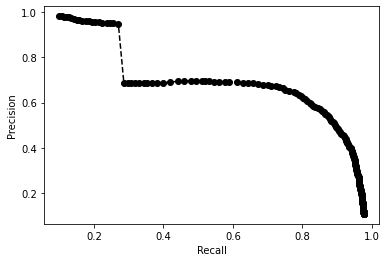

In [24]:
# minimum score threshold to test
min_threshold = -20.0
max_threshold = 2.0
step = 0.1
metrics.precision_recall_curve_at_threshold(weighted_relevant_names_test, candidates, min_threshold, max_threshold, step)

## Test

In [155]:
input_names_test[251]

'<bostelman>'

In [156]:
weighted_relevant_names_test[251]

[('<bostelmann>', 0.6784565916398714), ('<bostleman>', 0.3215434083601286)]

In [157]:
candidates[251,:5]

array([('<bostelman>', 1.        ), ('<bostelmann>', 0.9       ),
       ('<bostleman>', 0.77777778), ('<vosselman>', 0.77777778),
       ('<osterman>', 0.77777778)],
      dtype=[('name', 'O'), ('score', '<f8')])

In [158]:
metrics.recall_at_threshold(weighted_relevant_names_test[251], candidates[251], 0.85)

0.6784565916398714

In [159]:
metrics.recall_at_threshold(weighted_relevant_names_test[251], candidates[251], 0.75)

1.0